In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchvision import datasets
from torchvision import transforms as tf
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

import os,sys
root_dir='/mnt/e/Programming_Projects/CLDV_PRACTICAL/CVDL_Practical'
sys.path.append(root_dir)

from data.CK_plus import CK_plus
from data.FER2013 import FER2013
from data.utils.augmentations import randomErasing_flip_rotate_transforms
from models.utils.discriminativ_loss import AffinityLoss

from tqdm import tqdm_notebook as tqdm



In [3]:
class getcfg():
    def __init__(self):
        self.probability=0.8
        self.min_area=0.02
        self.max_area=0.10
        self.min_aspect_ratio=0.3
        self.max_aspect_ratio=3.0
        self.rotation_angle=25

cfg=getcfg()
cfg.rotation_angle

25

In [11]:
train_transform, test_transform = randomErasing_flip_rotate_transforms(cfg)['train'], randomErasing_flip_rotate_transforms(cfg)['test']

train_data = CK_plus(transform=train_transform,split='train')
test_data = CK_plus(transform=test_transform,split='test')

# # use fer
# train_data = FER2013(transform=train_transform,split='train')
# test_data = FER2013(transform=test_transform,split='test')

train_data_loader = DataLoader(train_data,batch_size=32,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=32,shuffle=True)



In [12]:
# definition of Attention feature map

#defining the attention block
class alighnment_score(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(alighnment_score,self).__init__()
        self.in_channels=in_channels
        self.out_channels=out_channels
        # self.fc_up = nn.Linear(in_channels,2*out_channels)
        # self.fc_down = nn.Linear(2*out_channels,out_channels)
        self.layernorm_in = nn.LayerNorm(in_channels)
        self.layernorm_out = nn.LayerNorm(out_channels)
        self.Q=nn.Linear(in_channels,out_channels)
        self.K=nn.Linear(in_channels,out_channels)
    def forward(self,x,value): # (b,16,8) (b,16,1,16,16)
        #print(f"input shape: {x.shape},value shape: {value.shape}")
        origin=value
        x=self.layernorm_in(x)
        Q=self.Q(x)
        K=self.K(x)
        alignment=torch.matmul(Q,K.transpose(-2,-1))/np.sqrt(self.out_channels)
        alighnment_score=F.softmax(alignment,dim=-1) #(b,16,16)
        #print(f"alignment shape after softmax: {alighnment_score.shape},transofrmed origin {value.squeeze(2).view(value.size(0),value.size(1),-1).shape}")
        
        # (b,16,16) (b,16,16,16)
        att=torch.matmul(alighnment_score,value.squeeze(2).view(value.size(0),value.size(1),-1))
        #print(f"after matmul: {att.shape}")
        
        #reshape the output
        att=att.view(value.size(0),value.size(1),1,value.size(3),value.size(4))
        
        att=att+origin
        #print(f"after reshape: {att.shape}")
        
        
        
        att=self.layernorm_out(att)
        
        #print(f"output shape: {att.shape}")
        return att
    
# testing the attention block
b=32
c=4*4
p=16
x=torch.randn(b,c,p)
value=torch.randn(b,c,1,p,p)
print(f"=====testing the attention block=====")
print(f"ATT input shape: {x.shape}")
attention=alighnment_score(in_channels=4*4,out_channels=16)
output=attention(x,value)
print(f"ATT output shape: {output.shape}")

# definine the convolution init layer
class window_init(nn.Module):
    def __init__(self,patch_size,dmodel):
        super(window_init,self).__init__()
        kernelsize=patch_size/dmodel**0.5
        assert kernelsize==int(kernelsize), f"patch size {patch_size} is not divisible by dmodel {dmodel**0,5}"
        kernelsize=int(kernelsize)
        self.conv=nn.Conv2d(1,1,kernel_size=kernelsize,stride=kernelsize)
        self.relu=nn.ReLU()
    def forward(self,x):
        x=self.conv(x)
        x=self.relu(x)
        return x

# testing the window init layer
b=32
c=1
h=64
w=64

x=torch.randn(b,c,h,w)
print(f"=====testing the window init layer=====")
print(f"input shape!!: {x.shape}")
window=window_init(16,64)
output=window(x)
print(f"output shape: {output.shape}")

# using torchvison resnet for after attention block
from torchvision.models import resnet18
class after_attention(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(after_attention,self).__init__()
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.resnet=resnet18(pretrained=False)
        self.resnet.fc=nn.Linear(512,out_channels)
        
    def forward(self,x):
        feature=x.view(x.size(0),-1)
        x=self.resnet(x.repeat(1,3,1,1))
        return feature,x
    

# define image split layer
class image_split(nn.Module):
    """
    Splits an image into patches of size (patch_size x patch_size).
    Input shape:  (B, C, H, W)
    Output shape: (B, N, C, patch_size, patch_size), where N = (H // patch_size) * (W // patch_size)
    """
    def __init__(self, patch_size: int):
        super().__init__()
        self.patch_size = patch_size

    def forward(self, x: torch.Tensor):
        """
        x: Input tensor of shape [B, C, H, W]
        """
        b, c, h, w = x.size()
        patch_size = self.patch_size
        
        num_patches = (h // patch_size) * (w // patch_size)
        vertical_patches = h // patch_size
        horizontal_patches = w // patch_size
        
        # Split the image into patches
        x = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        x = x.contiguous().view(b, c, num_patches, patch_size, patch_size)
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        
        return x
    
#define the image reconstruction layer
class image_reconstruction(nn.Module):
    """
    Reconstructs the original image from patches.
    Input shape:  (B, N, C, patch_size, patch_size), where N = (H // patch_size) * (W // patch_size)
    Output shape: (B, C, H, W)
    """
    def __init__(self, patch_size: int):
        super().__init__()
        self.patch_size = patch_size

    def forward(self, x: torch.Tensor, original_hw: tuple):
        """
        x: Tensor of shape [B, N, C, patch_size, patch_size]
        original_hw: Tuple (H, W) - original image dimensions
        """
        b, n, c, patch_size, _ = x.size()
        h, w = original_hw
        
        assert patch_size == self.patch_size, "Patch size mismatch during reconstruction"
        
        # Compute the number of patches along each dimension
        patches_h = h // patch_size
        patches_w = w // patch_size

        # Ensure the number of patches matches
        assert n == patches_h * patches_w, \
            f"Number of patches ({n}) does not match expected ({patches_h * patches_w})"

        # Reshape and permute to reconstruct the image
        x = x.view(b, patches_h, patches_w, c, patch_size, patch_size)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        x = x.view(b, c, h, w)

        return x

# defining the Attention feature cluster network
class AttentionFeatureCluster(nn.Module):
    def __init__(self,patch_size,feature_size,dmodel,num_classes):
        super(AttentionFeatureCluster,self).__init__()
        self.patch_size=patch_size
        self.feature_size=feature_size
        self.num_classes=num_classes
        self.num_patches=(self.feature_size//self.patch_size)**2
        self.window_init=window_init(self.patch_size,dmodel)
        self.attention=alighnment_score((8)**2, self.patch_size)
        
        self.after_attention=after_attention(self.feature_size**2,self.num_classes)
        
        self.att_image_split=image_split(8)
        self.image_split=image_split(self.patch_size)
        self.image_reconstruction=image_reconstruction(self.patch_size)
        
        self.dropout=nn.Dropout(0.5)
    def forward(self,x):
        b,c,h,w=x.size() # (b,1,64,64)
        value=self.image_split(x) # (b,16,16,16)
        #print(f"value shape after split: {value.shape}")
        
        
        x=self.window_init(x) # (b,1,4,4)
        x=self.dropout(x)
        
        
        
        x=self.att_image_split(x) # (b,16,16,16)
        #print(f"shape after split: {x.shape}")
        

        x=x.view(b,self.num_patches,-1) # (b,16,16)
        
        # apply the attention block
        x=self.attention(x,value)
        #print(f"shape after attention: {x.shape}") # (b,number_of_patches,1,16,16)
        # fig,ax=plt.subplots(1,5,figsize=(20,5))
        # ax[0].imshow(x[0,0,0].cpu().detach().numpy())
        # ax[1].imshow(x[0,1,0].cpu().detach().numpy())
        # ax[2].imshow(x[0,2,0].cpu().detach().numpy())
        # ax[3].imshow(x[0,3,0].cpu().detach().numpy())
        
        # reconstruct the image
        x=self.image_reconstruction(x,(64,64))
        plt.imshow(x[0,0].cpu().detach().numpy())
        #print(f"shape after reconstruction: {x.shape}")
        x=self.dropout(x)
        
        
        # apply the fc layer
        feature,x=self.after_attention(x)
        return feature,x
    


=====testing the attention block=====
ATT input shape: torch.Size([32, 16, 16])
input shape: torch.Size([32, 16, 16]),value shape: torch.Size([32, 16, 1, 16, 16])
alignment shape after softmax: torch.Size([32, 16, 16]),transofrmed origin torch.Size([32, 16, 256])
after matmul: torch.Size([32, 16, 256])
after reshape: torch.Size([32, 16, 1, 16, 16])
output shape: torch.Size([32, 16, 1, 16, 16])
ATT output shape: torch.Size([32, 16, 1, 16, 16])
=====testing the window init layer=====
input shape!!: torch.Size([32, 1, 64, 64])
output shape: torch.Size([32, 1, 32, 32])


image shape: torch.Size([32, 1, 64, 64])
shape after split: torch.Size([32, 16, 1, 16, 16])


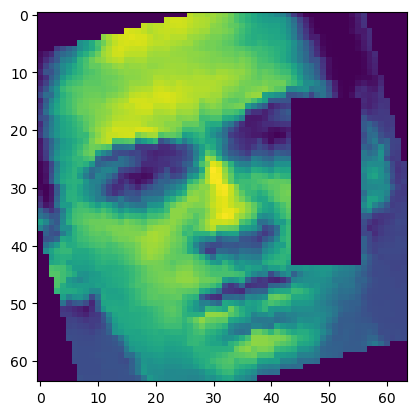

In [13]:
import torch
import torch.nn as nn

class ImageSplit(nn.Module):
    """
    Splits an image into patches of size (patch_size x patch_size).
    Input shape:  (B, C, H, W)
    Output shape: (B, N, C, patch_size, patch_size), where N = (H // patch_size) * (W // patch_size)
    """
    def __init__(self, patch_size: int):
        super().__init__()
        self.patch_size = patch_size

    def forward(self, x: torch.Tensor):
        """
        x: Input tensor of shape [B, C, H, W]
        """
        b, c, h, w = x.size()
        patch_size = self.patch_size
        
        num_patches = (h // patch_size) * (w // patch_size)
        vertical_patches = h // patch_size
        horizontal_patches = w // patch_size
        
        # Split the image into patches
        x = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        x = x.contiguous().view(b, c, num_patches, patch_size, patch_size)
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        
        return x


class ImageReconstruction(nn.Module):
    """
    Reconstructs the original image from patches.
    Input shape:  (B, N, C, patch_size, patch_size), where N = (H // patch_size) * (W // patch_size)
    Output shape: (B, C, H, W)
    """
    def __init__(self, patch_size: int):
        super().__init__()
        self.patch_size = patch_size

    def forward(self, x: torch.Tensor, original_hw: tuple):
        """
        x: Tensor of shape [B, N, C, patch_size, patch_size]
        original_hw: Tuple (H, W) - original image dimensions
        """
        b, n, c, patch_size, _ = x.size()
        h, w = original_hw
        
        assert patch_size == self.patch_size, "Patch size mismatch during reconstruction"
        
        # Compute the number of patches along each dimension
        patches_h = h // patch_size
        patches_w = w // patch_size

        # Ensure the number of patches matches
        assert n == patches_h * patches_w, \
            f"Number of patches ({n}) does not match expected ({patches_h * patches_w})"

        # Reshape and permute to reconstruct the image
        x = x.view(b, patches_h, patches_w, c, patch_size, patch_size)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        x = x.view(b, c, h, w)

        return x


# test image split and image reconstruction
img=next(iter(train_data_loader))[0]
print(f"image shape: {img.shape}")
plt.imshow(img[0,0].detach().cpu().numpy())
image_split_layer=ImageSplit(16)
image_reconstruction_layer=ImageReconstruction(16)
patches=image_split_layer(img)
print(f"shape after split: {patches.shape}")
reconstructed_img=image_reconstruction_layer(patches,(64,64))
plt.imshow(reconstructed_img[0,0].detach().cpu().numpy())


torch.Size([32, 1, 64, 64])


/root/miniconda3/envs/rapids-21.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/rapids-21.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])


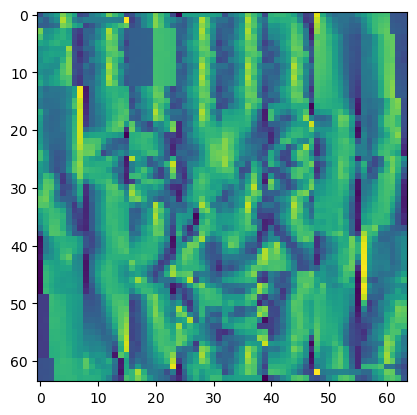

In [16]:
img=next(iter(train_data_loader))[0]
#plt.imshow(img[0,0].detach().cpu().numpy())
img=img.to('cuda')
print(img.shape)
attention_cluster=AttentionFeatureCluster(8,64,64,6)
attention_cluster=attention_cluster.to('cuda')
attention_cluster(img)[1].shape

plt.show()


/tmp/ipykernel_325866/3903676500.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm(train_data_loader):


  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])


/root/miniconda3/envs/rapids-21.12/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

/tmp/ipykernel_325866/3903676500.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm(test_data_loader):


  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

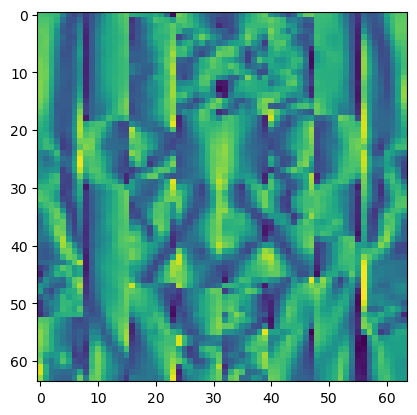

In [17]:
feature_loss=AffinityLoss(64*64,6)
feature_loss=feature_loss.to('cuda')
predic_loss=nn.CrossEntropyLoss()
predic_loss=predic_loss.to('cuda')

optimizer=optim.Adam(attention_cluster.parameters(),lr=0.001)

from tqdm import tqdm_notebook as tqdm

def train(model,train_data_loader,optimizer,feature_loss,predic_loss):
    model.train()
    total_loss=0
    total_correct=0
    for data in tqdm(train_data_loader):
        model.zero_grad()
        img,label=data
        img=img.to('cuda')
        label=label.to('cuda')
        feature,predic=model(img)
        loss1=0.1*feature_loss(feature,label)
        loss2=predic_loss(predic,label)
        loss=loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        total_correct+=predic.argmax(dim=1).eq(label.argmax(dim=1)).sum().item()
    return total_loss/len(train_data_loader),total_correct/len(train_data_loader.dataset)

def test(model,test_data_loader,feature_loss,predic_loss):
    model.eval()
    total_loss=0
    total_correct=0
    with torch.no_grad():
        for data in tqdm(test_data_loader):
            img,label=data
            img=img.to('cuda')
            label=label.to('cuda')
            feature,predic=model(img)
            loss1=feature_loss(feature,label)
            loss2=predic_loss(predic,label)
            loss=loss1+loss2
            total_loss+=loss.item()
            total_correct+=predic.argmax(dim=1).eq(label.argmax(dim=1)).sum().item()
    return total_loss/len(test_data_loader),total_correct/len(test_data_loader.dataset)

train_loss,train_acc=train(attention_cluster,train_data_loader,optimizer,feature_loss,predic_loss)
test_loss,test_acc=test(attention_cluster,test_data_loader,feature_loss,predic_loss)
print(f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}")
print(f"test_loss: {test_loss:.4f}, test_acc: {test_acc:.4f}")



/tmp/ipykernel_325866/774573625.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(num_epochs)):


  0%|          | 0/70 [00:00<?, ?it/s]

/tmp/ipykernel_325866/3903676500.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm(train_data_loader):


  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

/tmp/ipykernel_325866/3903676500.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm(test_data_loader):


  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/25 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

  0%|          | 0/7 [00:00<?, ?it/s]

value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after reconstruction: torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 64, 1, 8, 8])
shape after split: torch.Size([32, 64, 1, 8, 8])
input shape: torch.Size([32, 64, 64]),value shape: torch.Size([32, 64, 1, 8, 8])
alignment shape after softmax: torch.Size([32, 64, 64]),transofrmed origin torch.Size([32, 64, 64])
after matmul: torch.Size([32, 64, 64])
after reshape: torch.Size([32, 64, 1, 8, 8])
output shape: torch.Size([32, 64, 1, 8, 8])
shape after attention: torch.Size([32, 64, 1, 8, 8])
shape after 

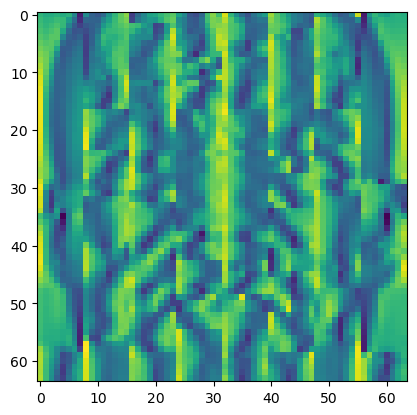

In [18]:
# training the model
num_epochs=70

for epoch in tqdm(range(num_epochs)):
    train_loss,train_acc=train(attention_cluster,train_data_loader,optimizer,feature_loss,predic_loss)
    test_loss,test_acc=test(attention_cluster,test_data_loader,feature_loss,predic_loss)
    print(f"Epoch: {epoch+1}/{num_epochs}")
    print(f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}")
    print(f"test_loss: {test_loss:.4f}, test_acc: {test_acc:.4f}")
    print("="*20)

In [8]:
# see activation map
from models.utils.visualization import visualize_gradients
img=next(iter(test_data_loader))[0]
img=img.to('cuda')
attention_cluster.eval()
feature,_=attention_cluster(img)
label=next(iter(test_data_loader))[1]
img_arr=visualize_gradients(model=attention_cluster,img=img,label=label,cfg=cfg)
print(img_arr.shape)

fig,ax=plt.subplots(4,8,figsize=(20,20))
for i in range(4):
    for j in range(8):
        ax[i,j].imshow(img_arr[i*4+j].transpose(1,2,0))
        ax[i,j].axis('off')



value shape after split: torch.Size([32, 4, 1, 32, 32])
shape after split: torch.Size([32, 4, 1, 8, 8])
input shape: torch.Size([32, 4, 64]),value shape: torch.Size([32, 4, 1, 32, 32])
alignment shape after softmax: torch.Size([32, 4, 4]),transofrmed origin torch.Size([32, 4, 1024])
after matmul: torch.Size([32, 4, 1024])
after reshape: torch.Size([32, 4, 1, 32, 32])
output shape: torch.Size([32, 4, 1, 32, 32])
shape after attention: torch.Size([32, 4, 1, 32, 32])
shape after reconstruction: torch.Size([32, 1, 64, 64])


NameError: name 'cfg' is not defined

In [ ]:
# hook feature map
feature=None

def hook_fn(module,input,output):
    global feature
    print(f"input: {input[0].shape}")
    feature=input
    output=output[0]
    
    feature=input

#attention_cluster=AttentionFeatureCluster(32,64,64,6).to('cuda')
attention_cluster.after_attention.register_forward_hook(hook_fn)
img=next(iter(test_data_loader))[0]
img=img.to('cuda')
attention_cluster.eval()
print(img.shape)
attention_cluster(img)
print(feature[0].shape)

plt.imshow(attention_cluster(img)[1]

torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 16, 1, 16, 16])
shape after split: torch.Size([32, 16, 1, 8, 8])
input shape: torch.Size([32, 16, 64]),value shape: torch.Size([32, 16, 1, 16, 16])
alignment shape after softmax: torch.Size([32, 16, 16]),transofrmed origin torch.Size([32, 16, 256])
after matmul: torch.Size([32, 16, 256])
after reshape: torch.Size([32, 16, 1, 16, 16])
output shape: torch.Size([32, 16, 1, 16, 16])
shape after attention: torch.Size([32, 16, 1, 16, 16])
shape after reconstruction: torch.Size([32, 1, 64, 64])
input: torch.Size([32, 1, 64, 64])
input: torch.Size([32, 1, 64, 64])
input: torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
value shape after split: torch.Size([32, 16, 1, 16, 16])
shape after split: torch.Size([32, 16, 1, 8, 8])
input shape: torch.Size([32, 16, 64]),value shape: torch.Size([32, 16, 1, 16, 16])
alignment shape after softmax: torch.Size([32, 16, 16]),transofrmed origin torch.Size([32, 16, 256])
after matmul: t

RuntimeError: shape '[64, 64]' is invalid for input of size 131072

In [299]:
feature.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [230]:
class mocked_cfg:
    def __init__(self):
        self.patch_size=32
        self.feature_size=64
        self.num_classes=6
        self.num_patches=(self.feature_size//self.patch_size)**2
        self.blur_size=11
        self.model='fcn'
        
cfg=mocked_cfg()